In [11]:
import random
import copy
import numpy as np
from itertools import combinations
from enum import Enum

## Game Definition

In [27]:
class Action(Enum):
    FOLD = 0
    CALL = 1
    RAISE = 2

class Stage(Enum):
    PREFLOP = 0
    FLOP = 1
    TURN = 2
    RIVER = 3
    SHOWDOWN = 4

class Card:
    def __init__(self, rank, suit):
        self.rank = rank
        self.suit = suit
    def __repr__(self):
        return f"{self.rank}{self.suit}"

def create_deck():
    ranks = ['2','3','4','5','6','7','8','9','T','J','Q','K','A']
    suits = ['H','D','C','S']
    deck = [Card(r,s) for r in ranks for s in suits]
    random.shuffle(deck)
    return deck

def card_value(c):
    order = {'2':2,'3':3,'4':4,'5':5,'6':6,'7':7,'8':8,'9':9,
             'T':10,'J':11,'Q':12,'K':13,'A':14}
    return order[c.rank]

def check_straight(vals):
    vals = sorted(set(vals))
    if len(vals) < 5:
        return False, None
    for i in range(len(vals)-4):
        window = vals[i:i+5]
        if window[-1] - window[0] == 4:
            return True, window[-1]
    if {14,2,3,4,5}.issubset(vals):
        return True, 5
    return False, None

def evaluate_5card_hand(cards):
    vals = sorted([card_value(c) for c in cards], reverse=True)
    suits = [c.suit for c in cards]
    flush = len(set(suits)) == 1
    straight, high = check_straight(vals)
    freq = {v: vals.count(v) for v in vals}
    freq_sorted = sorted(freq.items(), key=lambda x:(x[1], x[0]), reverse=True)
    if flush and straight:
        return (8, high)
    if freq_sorted[0][1] == 4:
        four = freq_sorted[0][0]
        kick = max(v for v in vals if v != four)
        return (7, four, kick)
    if freq_sorted[0][1] == 3 and len(freq_sorted)>1 and freq_sorted[1][1]>=2:
        return (6, freq_sorted[0][0], freq_sorted[1][0])
    if flush:
        return (5, tuple(vals))
    if straight:
        return (4, high)
    if freq_sorted[0][1] == 3:
        kickers = sorted([v for v in vals if v != freq_sorted[0][0]], reverse=True)
        return (3, freq_sorted[0][0], tuple(kickers))
    if len(freq_sorted)>=2 and freq_sorted[0][1]==2 and freq_sorted[1][1]==2:
        p1,p2 = freq_sorted[0][0], freq_sorted[1][0]
        kick = max(v for v in vals if v not in (p1,p2))
        return (2, max(p1,p2), min(p1,p2), kick)
    if freq_sorted[0][1] == 2:
        kickers = sorted([v for v in vals if v != freq_sorted[0][0]], reverse=True)
        return (1, freq_sorted[0][0], tuple(kickers))
    return (0, tuple(vals))

def evaluate_hand(hole, community):
    best = (-1,)
    for combo in combinations(hole+community, 5):
        rank = evaluate_5card_hand(combo)
        if rank > best:
            best = rank
    return best

In [28]:
class PokerGame:
    def __init__(self, agents):
        self.agents = agents
        self.stacks = [500 for _ in agents]  # 每个玩家初始500筹码
        self.active = [True for _ in agents]  # 是否还在场上
        self.deck = []
        self.hole_cards = [[] for _ in agents]
        self.community = []

    def reset(self):
        self.deck = create_deck()
        self.community = []
        self.hole_cards = [[self.deck.pop(), self.deck.pop()] for _ in self.agents]

    def deal_community(self, num):
        for _ in range(num):
            self.community.append(self.deck.pop())

    def showdown(self):
        hands = [evaluate_hand(hole, self.community) if self.active[i] else (-1,) for i, hole in enumerate(self.hole_cards)]
        winner = max(enumerate(hands), key=lambda x: x[1])[0]
        return winner

    def play_round(self):
        self.reset()

        pot = 0
        fold_status = [not self.active[i] for i in range(len(self.agents))]  # 淘汰的人默认弃牌

        # PREFLOP
        for i, agent in enumerate(self.agents):
            if self.active[i]:
                action = agent.act(self.hole_cards[i], self.community)
                if action == Action.FOLD:
                    fold_status[i] = True
                else:
                    if self.stacks[i] >= 1:
                        pot += 1
                        self.stacks[i] -= 1
                    else:
                        fold_status[i] = True

        # FLOP
        self.deal_community(3)
        for i, agent in enumerate(self.agents):
            if self.active[i] and not fold_status[i]:
                action = agent.act(self.hole_cards[i], self.community)
                if action == Action.FOLD:
                    fold_status[i] = True
                else:
                    if self.stacks[i] >= 1:
                        pot += 1
                        self.stacks[i] -= 1
                    else:
                        fold_status[i] = True

        # TURN
        self.deal_community(1)
        for i, agent in enumerate(self.agents):
            if self.active[i] and not fold_status[i]:
                action = agent.act(self.hole_cards[i], self.community)
                if action == Action.FOLD:
                    fold_status[i] = True
                else:
                    if self.stacks[i] >= 1:
                        pot += 1
                        self.stacks[i] -= 1
                    else:
                        fold_status[i] = True

        # RIVER
        self.deal_community(1)
        for i, agent in enumerate(self.agents):
            if self.active[i] and not fold_status[i]:
                action = agent.act(self.hole_cards[i], self.community)
                if action == Action.FOLD:
                    fold_status[i] = True
                else:
                    if self.stacks[i] >= 1:
                        pot += 1
                        self.stacks[i] -= 1
                    else:
                        fold_status[i] = True

        # Showdown
        active_players = [i for i, f in enumerate(fold_status) if not f and self.active[i]]
        if len(active_players) == 1:
            winner = active_players[0]
        elif len(active_players) >= 2:
            winner = self.showdown()
        else:
            return  # 如果没人能参与，跳过

        self.stacks[winner] += pot

        # 更新active状态
        for i, stack in enumerate(self.stacks):
            if stack <= 0:
                self.active[i] = False

## Tournament Definition

The 3 players on the table, each with an initial $500-size amount of chips, play a tournament consistently. If someone's chip value gets lower or equal to 0, he/she is eliminated from the game, while the rest continue to play. Eventually, the game ends with there's only one player remaining on the table, and that's the winner!

In [15]:
def play_tournament_with_logging():
    random_agent = RandomAgent()
    equity_agent = EquityAgent()
    cfr_agent = CFRAgent()

    agents = [random_agent, equity_agent, cfr_agent]
    agent_names = ['Random', 'Equity', 'CFR']

    game = PokerGame(agents)

    records = [[] for _ in agents]
    cfr_train_iters = 10
    hand_count = 0

    while sum(game.active) > 1:
        # 每局开始前 CFR 训练
        for _ in range(cfr_train_iters):
            cfr_agent.train([], [])

        # 保存手牌开始前的筹码
        prev_stacks = game.stacks.copy()

        game.play_round()

        # 记录本局后各个玩家筹码
        for idx, stack in enumerate(game.stacks):
            records[idx].append(stack)

        # 找出赢家
        stack_change = [game.stacks[i] - prev_stacks[i] for i in range(len(agents))]
        hand_winner_idx = max(range(len(agents)), key=lambda i: stack_change[i])

        print(f"Hand {hand_count+1}: {agent_names[hand_winner_idx]} wins {stack_change[hand_winner_idx]} chips")

        # 找出淘汰者
        for idx in range(len(agents)):
            if game.active[idx] == False and prev_stacks[idx] > 0:
                print(f"⚡ {agent_names[idx]} is eliminated!")

        hand_count += 1

    winner_idx = game.active.index(True)
    print("="*40)
    print(f"🏆 Tournament Winner: {agent_names[winner_idx]} after {hand_count} hands!")
    print("="*40)

    return records, agent_names

## Agent Definition

In [5]:
# random agent
class RandomAgent:
    def act(self, hole_cards, community_cards):
        return random.choice(list(Action))

In [6]:
# equity agent
class EquityAgent:
    def act(self, hole_cards, community_cards):
        if len(community_cards) < 5:
            return Action.CALL
        # 如果胜率高，激进
        equity = self.estimate_equity(hole_cards, community_cards)
        if equity > 0.6:
            return Action.RAISE
        elif equity > 0.4:
            return Action.CALL
        else:
            return Action.FOLD

    def estimate_equity(self, hole_cards, community_cards, n_simulations=20):
        wins = 0
        for _ in range(n_simulations):
            deck = create_deck()
            known = hole_cards + community_cards
            deck = [card for card in deck if card not in known]
            opp_hole = [deck.pop(), deck.pop()]
            remaining = community_cards + [deck.pop() for _ in range(5-len(community_cards))]
            my_hand = evaluate_hand(hole_cards, remaining)
            opp_hand = evaluate_hand(opp_hole, remaining)
            if my_hand > opp_hand:
                wins += 1
        return wins / n_simulations


In [7]:
class CFRAgent:
    def __init__(self):
        self.regret_sum = {a: 0 for a in Action}
        self.strategy_sum = {a: 0 for a in Action}

    def get_strategy(self):
        normalizing_sum = sum([max(r,0) for r in self.regret_sum.values()])
        if normalizing_sum > 0:
            strategy = {a: max(self.regret_sum[a],0)/normalizing_sum for a in Action}
        else:
            strategy = {a: 1/len(Action) for a in Action}
        return strategy

    def act(self, hole_cards, community_cards):
        strategy = self.get_strategy()
        actions = list(strategy.keys())
        probs = list(strategy.values())
        action = random.choices(actions, probs)[0]
        return action

    def train(self, hole_cards, community_cards):
        strategy = self.get_strategy()
        util = {a: 0 for a in Action}

        # 随机模拟一次对手（random agent）
        opp_action = random.choice(list(Action))
        opp_utility = 1 if opp_action == Action.FOLD else -1

        for a in Action:
            if a == Action.RAISE:
                util[a] = 1
            elif a == Action.CALL:
                util[a] = 0
            else:  # FOLD
                util[a] = -1

        node_utility = sum([strategy[a] * util[a] for a in Action])
        for a in Action:
            regret = util[a] - node_utility
            self.regret_sum[a] += regret

## Plot

In [8]:
import matplotlib.pyplot as plt

def plot_records(records, agent_names):
    plt.figure(figsize=(10,6))
    for idx, rec in enumerate(records):
        if rec:  # 只画有记录的玩家
            plt.plot(rec, label=agent_names[idx])
    plt.xlabel("Hand Number")
    plt.ylabel("Stack Size")
    plt.title("Agent Tournament Evolution")
    plt.legend()
    plt.grid()
    plt.show()


## Training, Running and Data Visualization

Hand 1: Random wins 8 chips
Hand 2: CFR wins 6 chips
Hand 3: Random wins 7 chips
Hand 4: Random wins 8 chips
Hand 5: CFR wins 5 chips
Hand 6: Equity wins 7 chips
Hand 7: Equity wins 4 chips
Hand 8: CFR wins 5 chips
Hand 9: CFR wins 4 chips
Hand 10: Equity wins 4 chips
Hand 11: Equity wins 5 chips
Hand 12: Equity wins 4 chips
Hand 13: Random wins 8 chips
Hand 14: Random wins 7 chips
Hand 15: Equity wins 4 chips
Hand 16: CFR wins 3 chips
Hand 17: CFR wins 6 chips
Hand 18: CFR wins 4 chips
Hand 19: CFR wins 8 chips
Hand 20: CFR wins 5 chips
Hand 21: Equity wins 6 chips
Hand 22: Equity wins 8 chips
Hand 23: CFR wins 3 chips
Hand 24: Random wins 7 chips
Hand 25: Equity wins 5 chips
Hand 26: CFR wins 4 chips
Hand 27: CFR wins 6 chips
Hand 28: Random wins 8 chips
Hand 29: CFR wins 4 chips
Hand 30: Random wins 7 chips
Hand 31: CFR wins 6 chips
Hand 32: CFR wins 4 chips
Hand 33: CFR wins 6 chips
Hand 34: CFR wins 4 chips
Hand 35: CFR wins 3 chips
Hand 36: Equity wins 5 chips
Hand 37: CFR wins 5

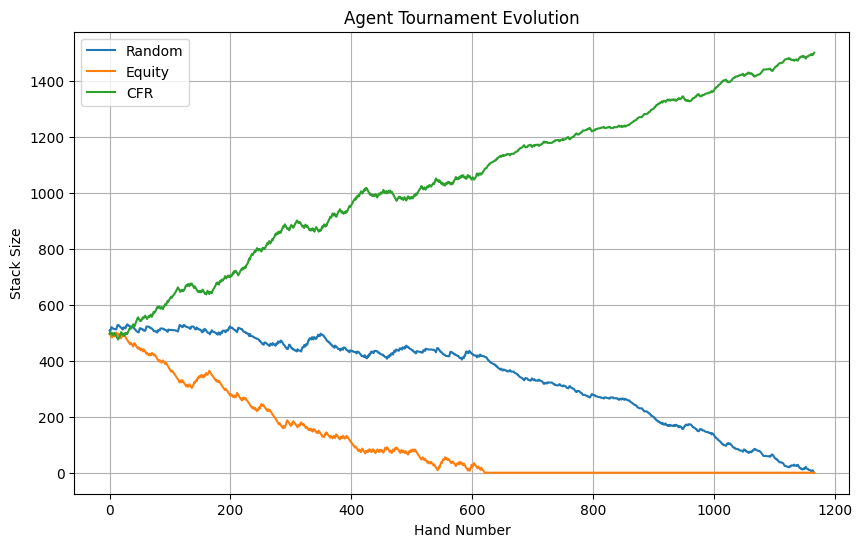

In [16]:
if __name__ == "__main__":
    records, agent_names = play_tournament_with_logging()
    plot_records(records, agent_names)

While our insights into the games among CFR, Equity, and Random player are legit, we still want to let the DQNAgent join the game!

## Class Definition

In [34]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import deque
from itertools import combinations
from enum import Enum

In [35]:
class Action(Enum):
    FOLD = 0
    CALL = 1
    RAISE = 2

class Card:
    def __init__(self, rank, suit):
        self.rank = rank
        self.suit = suit
    def __repr__(self):
        return f"{self.rank}{self.suit}"

def create_deck():
    ranks = ['2','3','4','5','6','7','8','9','T','J','Q','K','A']
    suits = ['H','D','C','S']
    deck = [Card(r,s) for r in ranks for s in suits]
    random.shuffle(deck)
    return deck

def card_value(c):
    order = {'2':2,'3':3,'4':4,'5':5,'6':6,'7':7,'8':8,'9':9,
             'T':10,'J':11,'Q':12,'K':13,'A':14}
    return order[c.rank]

def check_straight(vals):
    vals = sorted(set(vals))
    if len(vals) < 5:
        return False, None
    for i in range(len(vals)-4):
        window = vals[i:i+5]
        if window[-1] - window[0] == 4:
            return True, window[-1]
    if {14,2,3,4,5}.issubset(vals):
        return True, 5
    return False, None

def evaluate_5card_hand(cards):
    vals = sorted([card_value(c) for c in cards], reverse=True)
    suits = [c.suit for c in cards]
    flush = len(set(suits)) == 1
    straight, high = check_straight(vals)
    freq = {v: vals.count(v) for v in vals}
    freq_sorted = sorted(freq.items(), key=lambda x:(x[1], x[0]), reverse=True)
    if flush and straight:
        return (8, high)
    if freq_sorted[0][1] == 4:
        four = freq_sorted[0][0]
        kick = max(v for v in vals if v != four)
        return (7, four, kick)
    if freq_sorted[0][1] == 3 and len(freq_sorted)>1 and freq_sorted[1][1]>=2:
        return (6, freq_sorted[0][0], freq_sorted[1][0])
    if flush:
        return (5, tuple(vals))
    if straight:
        return (4, high)
    if freq_sorted[0][1] == 3:
        kickers = sorted([v for v in vals if v != freq_sorted[0][0]], reverse=True)
        return (3, freq_sorted[0][0], tuple(kickers))
    if len(freq_sorted)>=2 and freq_sorted[0][1]==2 and freq_sorted[1][1]==2:
        p1,p2 = freq_sorted[0][0], freq_sorted[1][0]
        kick = max(v for v in vals if v not in (p1,p2))
        return (2, max(p1,p2), min(p1,p2), kick)
    if freq_sorted[0][1] == 2:
        kickers = sorted([v for v in vals if v != freq_sorted[0][0]], reverse=True)
        return (1, freq_sorted[0][0], tuple(kickers))
    return (0, tuple(vals))

def evaluate_hand(hole, community):
    best = (-1,)
    for combo in combinations(hole+community, 5):
        rank = evaluate_5card_hand(combo)
        if rank > best:
            best = rank
    return best

## Agent Definition

In [36]:
class RandomAgent:
    def act(self, hole_cards, community_cards):
        return random.choice(list(Action))

class EquityAgent:
    def act(self, hole_cards, community_cards):
        if len(community_cards) < 5:
            return Action.CALL
        equity = self.estimate_equity(hole_cards, community_cards)
        if equity > 0.6:
            return Action.RAISE
        elif equity > 0.4:
            return Action.CALL
        else:
            return Action.FOLD

    def estimate_equity(self, hole_cards, community_cards, n_simulations=20):
        wins = 0
        for _ in range(n_simulations):
            deck = create_deck()
            known = hole_cards + community_cards
            deck = [card for card in deck if card not in known]
            opp_hole = [deck.pop(), deck.pop()]
            remaining = community_cards + [deck.pop() for _ in range(5-len(community_cards))]
            my_hand = evaluate_hand(hole_cards, remaining)
            opp_hand = evaluate_hand(opp_hole, remaining)
            if my_hand > opp_hand:
                wins += 1
        return wins / n_simulations

class CFRAgent:
    def __init__(self):
        self.regret_sum = {a: 0 for a in Action}
        self.strategy_sum = {a: 0 for a in Action}

    def get_strategy(self):
        normalizing_sum = sum([max(r,0) for r in self.regret_sum.values()])
        if normalizing_sum > 0:
            strategy = {a: max(self.regret_sum[a],0)/normalizing_sum for a in Action}
        else:
            strategy = {a: 1/len(Action) for a in Action}
        return strategy

    def act(self, hole_cards, community_cards):
        strategy = self.get_strategy()
        actions = list(strategy.keys())
        probs = list(strategy.values())
        return random.choices(actions, probs)[0]

    def train(self, hole_cards, community_cards):
        strategy = self.get_strategy()
        util = {a: 0 for a in Action}
        opp_action = random.choice(list(Action))
        for a in Action:
            if a == Action.RAISE:
                util[a] = 1
            elif a == Action.CALL:
                util[a] = 0
            else:
                util[a] = -1
        node_utility = sum([strategy[a] * util[a] for a in Action])
        for a in Action:
            regret = util[a] - node_utility
            self.regret_sum[a] += regret

In [37]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, *transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        return map(np.array, zip(*batch))

    def __len__(self):
        return len(self.buffer)

class DQNPokerNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQNPokerNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.out = nn.Linear(64, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)

class DQNAgent:
    def __init__(self, state_dim=11, action_dim=3):
        self.policy_net = DQNPokerNet(state_dim, action_dim)
        self.target_net = DQNPokerNet(state_dim, action_dim)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=1e-3)
        self.buffer = ReplayBuffer(10000)
        self.gamma = 0.99
        self.batch_size = 32
        self.epsilon = 0.1
        self.stack = 500
        self.last_state = None
        self.last_action = None

    def encode_state(self, hole_cards, community_cards):
        values = [card_value(c) for c in hole_cards + community_cards]
        values += [0] * (7 - len(values))
        stage = len(community_cards)
        hole_strength = sum(card_value(c) for c in hole_cards) / 28.0
        pot_size = len(community_cards)
        my_stack_ratio = self.stack / 500.0
        return np.array(values + [stage/5, hole_strength, pot_size/5, my_stack_ratio])

    def act(self, hole_cards, community_cards):
        state = self.encode_state(hole_cards, community_cards)
        self.last_state = state
        if random.random() < self.epsilon:
            action = random.choice(list(Action))
        else:
            with torch.no_grad():
                q_vals = self.policy_net(torch.FloatTensor(state))
                action = list(Action)[q_vals.argmax().item()]
        self.last_action = action
        return action

    def observe(self, reward, hole_cards, community_cards, done):
        if self.last_state is None or self.last_action is None:
            return
        next_state = self.encode_state(hole_cards, community_cards)
        self.buffer.push(self.last_state, self.last_action.value, reward, next_state, done)
        self.last_state = None
        self.last_action = None
        self.train()

    def train(self):
        if len(self.buffer) < self.batch_size:
            return
        states, actions, rewards, next_states, dones = self.buffer.sample(self.batch_size)
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.BoolTensor(dones)

        q_values = self.policy_net(states).gather(1, actions.unsqueeze(1)).squeeze()
        with torch.no_grad():
            next_q = self.target_net(next_states).max(1)[0]
            target = rewards + self.gamma * next_q * (~dones)
        loss = F.mse_loss(q_values, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

## Need Some Adjustment for Poker Game

In [38]:
class PokerGame:
    def __init__(self, agents):
        self.agents = agents
        self.stacks = [500 for _ in agents]  # 每人初始500筹码
        self.active = [True for _ in agents]  # 还在场上的标志
        self.deck = []
        self.hole_cards = [[] for _ in agents]
        self.community = []

    def reset(self):
        self.deck = create_deck()
        self.community = []
        self.hole_cards = [[self.deck.pop(), self.deck.pop()] for _ in self.agents]

    def deal_community(self, num):
        for _ in range(num):
            self.community.append(self.deck.pop())

    def showdown(self):
        hands = [evaluate_hand(hole, self.community) if self.active[i] else (-1,) for i, hole in enumerate(self.hole_cards)]
        winner = max(enumerate(hands), key=lambda x: x[1])[0]
        return winner

    def play_round(self):
        self.reset()

        pot = 0
        fold_status = [not self.active[i] for i in range(len(self.agents))]

        # PREFLOP
        for i, agent in enumerate(self.agents):
            if self.active[i]:
                action = agent.act(self.hole_cards[i], self.community)
                if action == Action.FOLD:
                    fold_status[i] = True
                else:
                    if self.stacks[i] >= 1:
                        pot += 1
                        self.stacks[i] -= 1
                    else:
                        fold_status[i] = True

        # FLOP
        self.deal_community(3)
        for i, agent in enumerate(self.agents):
            if self.active[i] and not fold_status[i]:
                action = agent.act(self.hole_cards[i], self.community)
                if action == Action.FOLD:
                    fold_status[i] = True
                else:
                    if self.stacks[i] >= 1:
                        pot += 1
                        self.stacks[i] -= 1
                    else:
                        fold_status[i] = True

        # TURN
        self.deal_community(1)
        for i, agent in enumerate(self.agents):
            if self.active[i] and not fold_status[i]:
                action = agent.act(self.hole_cards[i], self.community)
                if action == Action.FOLD:
                    fold_status[i] = True
                else:
                    if self.stacks[i] >= 1:
                        pot += 1
                        self.stacks[i] -= 1
                    else:
                        fold_status[i] = True

        # RIVER
        self.deal_community(1)
        for i, agent in enumerate(self.agents):
            if self.active[i] and not fold_status[i]:
                action = agent.act(self.hole_cards[i], self.community)
                if action == Action.FOLD:
                    fold_status[i] = True
                else:
                    if self.stacks[i] >= 1:
                        pot += 1
                        self.stacks[i] -= 1
                    else:
                        fold_status[i] = True

        # SHOWDOWN
        active_players = [i for i, f in enumerate(fold_status) if not f and self.active[i]]
        if len(active_players) == 1:
            winner = active_players[0]
        elif len(active_players) >= 2:
            winner = self.showdown()
        else:
            return  # 没人继续，空过

        self.stacks[winner] += pot

        # 检查是否有人筹码归0
        for i in range(len(self.stacks)):
            if self.stacks[i] <= 0:
                self.active[i] = False

## Redefine the tournament

In [39]:
def play_dqn_tournament():
    agents = [
        RandomAgent(),
        EquityAgent(),
        CFRAgent(),
        DQNAgent()
    ]
    agent_names = ['Random', 'Equity', 'CFR', 'DQN']

    game = PokerGame(agents)
    records = [[] for _ in agents]
    cfr_train_iters = 10
    hand_count = 0

    while sum(game.active) > 1:
        for _ in range(cfr_train_iters):
            if isinstance(agents[2], CFRAgent):
                agents[2].train([], [])

        prev_stacks = game.stacks.copy()
        game.play_round()

        # 给DQN奖励
        for idx, agent in enumerate(agents):
            if isinstance(agent, DQNAgent):
                reward = game.stacks[idx] - prev_stacks[idx]
                done = game.stacks[idx] <= 0
                agent.observe(reward, game.hole_cards[idx], game.community, done)

        # 记录本局堆叠
        for idx in range(len(agents)):
            records[idx].append(game.stacks[idx])

        # 输出赢家
        stack_change = [game.stacks[i] - prev_stacks[i] for i in range(len(agents))]
        winner_idx = max(range(len(agents)), key=lambda i: stack_change[i])
        print(f"Hand {hand_count + 1}: {agent_names[winner_idx]} wins {stack_change[winner_idx]} chips")

        # 输出淘汰者
        for idx in range(len(agents)):
            if game.stacks[idx] <= 0 and game.active[idx]:
                print(f"⚡ {agent_names[idx]} is eliminated!")
                game.active[idx] = False

        hand_count += 1

    final_winner = agent_names[game.active.index(True)]
    print(f"\n🏆 Tournament Winner: {final_winner} after {hand_count} hands!\n")
    return records, agent_names

## Plot

In [40]:
def plot_records(records, agent_names):
    plt.figure(figsize=(10,6))
    for idx, rec in enumerate(records):
        if rec:
            plt.plot(rec, label=agent_names[idx])
    plt.xlabel("Hand Number")
    plt.ylabel("Stack Size")
    plt.title("Tournament Evolution: DQN vs CFR vs Equity vs Random")
    plt.legend()
    plt.grid()
    plt.show()

## Training, Running, and Data Visualization

流式输出内容被截断，只能显示最后 5000 行内容。
Hand 9224: Random wins 0 chips
Hand 9225: Random wins 0 chips
Hand 9226: Random wins 0 chips
Hand 9227: Random wins 0 chips
Hand 9228: Random wins 0 chips
Hand 9229: Random wins 0 chips
Hand 9230: Random wins 0 chips
Hand 9231: Random wins 0 chips
Hand 9232: Random wins 0 chips
Hand 9233: Random wins 0 chips
Hand 9234: CFR wins 1 chips
Hand 9235: Random wins 0 chips
Hand 9236: Random wins 0 chips
Hand 9237: Random wins 0 chips
Hand 9238: Random wins 0 chips
Hand 9239: Random wins 0 chips
Hand 9240: Random wins 0 chips
Hand 9241: Random wins 0 chips
Hand 9242: Random wins 0 chips
Hand 9243: Random wins 0 chips
Hand 9244: Random wins 0 chips
Hand 9245: Random wins 0 chips
Hand 9246: Random wins 0 chips
Hand 9247: CFR wins 1 chips
Hand 9248: Random wins 0 chips
Hand 9249: Random wins 0 chips
Hand 9250: Random wins 0 chips
Hand 9251: Random wins 0 chips
Hand 9252: Random wins 0 chips
Hand 9253: Random wins 0 chips
Hand 9254: Random wins 0 chips
Hand 9255: Random 

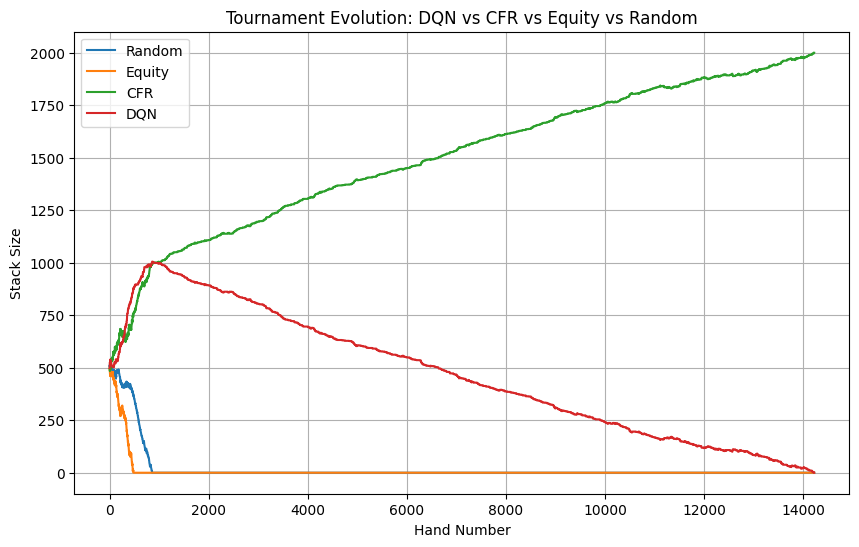

In [41]:
if __name__ == "__main__":
    records, agent_names = play_dqn_tournament()
    plot_records(records, agent_names)